In this notebook, we try to replicate the results in
[Remanufacturing end-of-life silicon photovoltaics: Feasibility and viability analysis](https://onlinelibrary.wiley.com/doi/full/10.1002/pip.3376).  

In [1]:
# pip install gdown

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import importlib.util
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

In [3]:
# Download unit conversion module
file_id = "1by8ZryyOzj55ZsJx6tWkXCH-aw1DDktO"
output = "unit_conversion.py"
gdown.download(id=file_id, output=output, quiet=False)
from unit_conversion import convert_dataframe_units, conversion_matrix

Downloading...
From (original): https://drive.google.com/uc?id=1by8ZryyOzj55ZsJx6tWkXCH-aw1DDktO
From (redirected): https://drive.google.com/uc?id=1by8ZryyOzj55ZsJx6tWkXCH-aw1DDktO&confirm=t&uuid=54fadc6d-d4b9-409a-91c6-821173864af0
To: /Users/mrr660/Documents/Research/Circular Economy/Summer 25/Deng et al_EOL PV/Jupyter Notebook/unit_conversion.py
100%|██████████████████████████████████████| 1.91k/1.91k [00:00<00:00, 2.56MB/s]


In [5]:
# Print conversion matrix
print("Conversion Matrix:")
print(conversion_matrix)

Conversion Matrix:
                kg     wafer      cell      module        Wp
kg        1.000000  0.015000  0.015000    0.900000  0.002840
wafer    66.666667  1.000000  1.000000   60.000000  0.189333
cell     66.666667  1.000000  1.000000   60.000000  0.189333
module    1.111111  0.016667  0.016667    1.000000  0.003220
Wp      352.112667  5.281690  5.281690  310.563372  1.000000


In [7]:
# Constants
kg_per_wafer = 0.016  # kg/wafer
cells_per_module = 60
cell_area_m2 = 331e-4  # 331 cm² → 0.0331 m²
irradiance = 1000  # W/m² (STC)
CTM_ratio = 0.99
median_efficiency = 23  # %

In [9]:
# Calculate power constant for contour plots
K = cells_per_module * irradiance * cell_area_m2 * CTM_ratio / 100  # W per % efficiency

In [11]:
# Production step cost data
production_step_data = {
    'Production Step': [
        'Purchase mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
        'Recycled mg-Si',
        'Recycled SOG poly-Si',
        'Recycled Mono wafer'
    ],
    'Unit': ['kg', 'kg', 'wafer', 'cell', 'module', 'kg', 'kg', 'cell'],
    'Distribution': ['Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Log-normal', 'Uniform', 'Uniform', 'Uniform'],
    'Process Cost': [3.97, 9.5, 0.36, 0.32, 49, 2.38, 7.65, 0.3675],
    'Process Cost Range': [
        (3.18, 4.76),
        (7.6, 11.4),
        (0.29, 0.43),
        (0.26, 0.38),
        (39, 59),
        (0, 4.76),
        (0, 15.3),
        (0, 0.735)
    ]
}

production_step_df = pd.DataFrame(production_step_data)
print("\nProduction Step Data:")
print(production_step_df)


Production Step Data:
                        Production Step    Unit Distribution  Process Cost  \
0                        Purchase mg-Si      kg   Log-normal        3.9700   
1      SoG Poly-Si (exclude mg-Si cost)      kg   Log-normal        9.5000   
2     Mono Wafer (exclude poly-Si cost)   wafer   Log-normal        0.3600   
3   Mono PERC cell (exclude wafer cost)    cell   Log-normal        0.3200   
4  Mono PERC module (exclude cell cost)  module   Log-normal       49.0000   
5                        Recycled mg-Si      kg      Uniform        2.3800   
6                  Recycled SOG poly-Si      kg      Uniform        7.6500   
7                   Recycled Mono wafer    cell      Uniform        0.3675   

  Process Cost Range  
0       (3.18, 4.76)  
1        (7.6, 11.4)  
2       (0.29, 0.43)  
3       (0.26, 0.38)  
4           (39, 59)  
5          (0, 4.76)  
6          (0, 15.3)  
7         (0, 0.735)  


In [13]:
# Set to 1 if you want to use ITRPV values instead of defaults
replace_with_ITRPV = 0

if replace_with_ITRPV:
    uncertainty = .2
    file_id = "14FpzNA7HSQ6spP-dq_u0UOv6nMVYT57I"
    output = "manufacturing_values.py"
    gdown.download(id=file_id, output=output, quiet=False)

    spec = importlib.util.spec_from_file_location("manufacturing_values", output)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    manufacturing_values_20 = pd.DataFrame([module.manufacturing_values_20])
    interpolated_row = module.manufacturing_values_20

    step_to_column = {
        'Purchase mg-Si': 'mg-Si ($/kg)',
        'SoG Poly-Si (exclude mg-Si cost)': 'poly-Si ($/kg)',
        'Mono Wafer (exclude poly-Si cost)': 'mono-wafer ($/wafer)',
        'Mono PERC cell (exclude wafer cost)': 'mono-cell ($/cell)',
        'Mono PERC module (exclude cell cost)': 'mono-module ($/module)'
    }

    new_process_costs = []
    new_process_cost_ranges = []
    for step in production_step_data['Production Step']:
        if step in step_to_column:
            col = step_to_column[step]
            value = interpolated_row[col]
            new_process_costs.append(value)
            new_process_cost_ranges.append((value * (1 - uncertainty), value * (1 + uncertainty)))
        else:
            index = production_step_data['Production Step'].index(step)
            new_process_costs.append(production_step_data['Process Cost'][index])
            new_process_cost_ranges.append(production_step_data['Process Cost Range'][index])

    production_step_data['Process Cost'] = new_process_costs
    production_step_data['Process Cost Range'] = new_process_cost_ranges
    production_step_df = pd.DataFrame(production_step_data)

    # Adjust recycling cost ranges
    idx = production_step_df.query("`Production Step` == 'Recycled mg-Si'").index[0]
    mg_si_max = production_step_df.loc[production_step_df['Production Step'] == 'Purchase mg-Si', 'Process Cost Range'].values[0][1]
    production_step_df.at[idx, 'Process Cost Range'] = (0, mg_si_max)

    idx = production_step_df.query("`Production Step` == 'Recycled SOG poly-Si'").index[0]
    sog_si_max = production_step_df.loc[production_step_df['Production Step'] == 'SoG Poly-Si (exclude mg-Si cost)', 'Process Cost Range'].values[0][1]
    production_step_df.at[idx, 'Process Cost Range'] = (0, sog_si_max+mg_si_max)

    idx = production_step_df.query("`Production Step` == 'Recycled Mono wafer'").index[0]
    cell_si_max = production_step_df.loc[production_step_df['Production Step'] == 'Mono PERC cell (exclude wafer cost)', 'Process Cost Range'].values[0][1]
    cell_si_max_total = (sog_si_max+mg_si_max)*conversion_matrix.at['kg', 'cell']+ cell_si_max
    production_step_df.at[idx, 'Process Cost Range'] = (0, cell_si_max_total)

    print("\nUpdated Production Step Data with ITRPV values:")
    print(production_step_df)

In [15]:
# Scenario definitions
scenario_steps = {
    'A': [
        'Purchase mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'B': [
        'Recycled mg-Si',
        'SoG Poly-Si (exclude mg-Si cost)',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'C': [
        'Recycled SOG poly-Si',
        'Mono Wafer (exclude poly-Si cost)',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ],
    'D': [
        'Recycled Mono wafer',
        'Mono PERC cell (exclude wafer cost)',
        'Mono PERC module (exclude cell cost)',
    ]
}

In [17]:
# Create scenario mapping
scenario_step_map = []
for scenario, steps in scenario_steps.items():
    for step in steps:
        row = production_step_df[production_step_df['Production Step'].str.lower() == step.lower()].iloc[0].to_dict()
        row['Scenario'] = scenario
        scenario_step_map.append(row)

df = pd.DataFrame(scenario_step_map)
cols = ['Scenario'] + [col for col in df.columns if col != 'Scenario']
df = df[cols]

print("\nScenario Data:")
print(df)


Scenario Data:
   Scenario                       Production Step    Unit Distribution  \
0         A                        Purchase mg-Si      kg   Log-normal   
1         A      SoG Poly-Si (exclude mg-Si cost)      kg   Log-normal   
2         A     Mono Wafer (exclude poly-Si cost)   wafer   Log-normal   
3         A   Mono PERC cell (exclude wafer cost)    cell   Log-normal   
4         A  Mono PERC module (exclude cell cost)  module   Log-normal   
5         B                        Recycled mg-Si      kg      Uniform   
6         B      SoG Poly-Si (exclude mg-Si cost)      kg   Log-normal   
7         B     Mono Wafer (exclude poly-Si cost)   wafer   Log-normal   
8         B   Mono PERC cell (exclude wafer cost)    cell   Log-normal   
9         B  Mono PERC module (exclude cell cost)  module   Log-normal   
10        C                  Recycled SOG poly-Si      kg      Uniform   
11        C     Mono Wafer (exclude poly-Si cost)   wafer   Log-normal   
12        C   Mono PER

In [19]:
# Efficiency data
efficiency_data = {
    'Scenario': ['A', 'B', 'C', 'D'],
    'Distribution': ['Normal', 'Uniform', 'Uniform', 'Uniform'],
    'Median Efficiency': [23, 23, 20.5, 20.5],
    'Efficiency Range': [
        (22.5, 23.5),
        (21, 22),
        (18, 23),
        (18, 23),
    ]
}
efficiency_df = pd.DataFrame(efficiency_data)

print("\nEfficiency Data:")
print(efficiency_df)


Efficiency Data:
  Scenario Distribution  Median Efficiency Efficiency Range
0        A       Normal               23.0     (22.5, 23.5)
1        B      Uniform               23.0         (21, 22)
2        C      Uniform               20.5         (18, 23)
3        D      Uniform               20.5         (18, 23)


In [21]:
# Production type filters
polysilicon_steps = [
    'Purchase mg-Si',
    'SoG Poly-Si (exclude mg-Si cost)',
    'Recycled mg-Si',
    'Recycled SOG poly-Si'
]

wafer_steps = polysilicon_steps + [
    'Mono Wafer (exclude poly-Si cost)',
    'Recycled Mono wafer'
]

cell_steps = wafer_steps + [
    'Mono PERC cell (exclude wafer cost)',
    'Recycled cell'
]

In [23]:
# Define the functions
def filter_rows_by_production_type(df, production_type, scenario):
    """Filter dataframe rows based on production type and scenario"""
    df_scenario = df[df['Scenario'] == scenario]
    if production_type == 'SoG Si':
        return df_scenario[df_scenario['Production Step'].isin(polysilicon_steps)]
    elif production_type == 'wafer':
        return df_scenario[df_scenario['Production Step'].isin(wafer_steps)]
    elif production_type == 'cell':
        return df_scenario[df_scenario['Production Step'].isin(cell_steps)]
    elif production_type == 'module':
        return df_scenario
    else:
        raise ValueError(f"Unknown production_type: {production_type}")

def generate_total_cost(df, n_samples):
    """Generate total cost distribution from DataFrame"""
    samples = {}
    for idx, row in df.iterrows():
        step = row['Production Step']
        median = row['Process Cost']
        dist_type = row['Distribution']
        low, high = row['Process Cost Range']

        if dist_type.lower() == 'log-normal':
            mu = np.log(median)
            sigma = (np.log(high) - np.log(low)) / 4
            samples[step] = np.random.lognormal(mean=mu, sigma=sigma, size=n_samples)
        elif dist_type.lower() == 'uniform':
            samples[step] = np.random.uniform(low=low, high=high, size=n_samples)
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    total_cost = np.sum(np.array(list(samples.values())), axis=0)
    return total_cost

def get_efficiency_distribution(efficiency_df, scenario, n_samples):
    """Get efficiency distribution for given scenario"""
    row = efficiency_df[efficiency_df['Scenario'] == scenario]
    distribution = row['Distribution'].values[0]
    median = row['Median Efficiency'].values[0]
    low, high = row['Efficiency Range'].values[0]

    if distribution.lower() == 'uniform':
        samples = np.random.uniform(low, high, n_samples)
    elif distribution.lower() == 'normal':
        std_dev = (high - low) / 4
        samples = np.random.normal(loc=median, scale=std_dev, size=n_samples)
    else:
        raise ValueError(f"Unsupported distribution type: {distribution}")

    return samples

def generate_costs_by_scenario(df, production_type, target_unit, conversion_matrix):
    """Generate cost distributions for all scenarios"""
    scenarios = df['Scenario'].unique().tolist()
    cost_results = {}
    n_samples = 100000

    for scenario in scenarios:
        filtered_df = filter_rows_by_production_type(df, production_type, scenario)
        filtered_df = convert_dataframe_units(filtered_df, target_unit, conversion_matrix)
        total_cost = generate_total_cost(filtered_df, n_samples)

        if target_unit == 'Wp':
            efficiencies = get_efficiency_distribution(efficiency_df, scenario, n_samples)
            efficiency_reference = efficiency_df[efficiency_df['Scenario'] == 'A']
            reference_efficiency = efficiency_reference['Median Efficiency'].values[0]
            efficiency_ratio = efficiencies / reference_efficiency
            total_cost = total_cost / efficiency_ratio

        cost_results[scenario] = total_cost

    return cost_results

def plot_cost_distribution(cost_array, title, target_unit, colors):
    """Plot cost distribution histograms"""
    plt.figure(figsize=(10, 6))
    for i, (label, cost_array) in enumerate(cost_array.items()):
        if not isinstance(cost_array, np.ndarray) or cost_array.size == 0:
            print(f"Skipping scenario {label}: invalid or empty data")
            continue
        sns.histplot(cost_array, bins=100, alpha=0.5, kde=True, label=label,
                    stat="probability", color=colors[i])

    plt.title(title)
    plt.xlabel(f'Cost ($/{target_unit})')
    plt.ylabel('Probability')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Analyzing SoG Si costs per kg...
Skipping scenario D: invalid or empty data


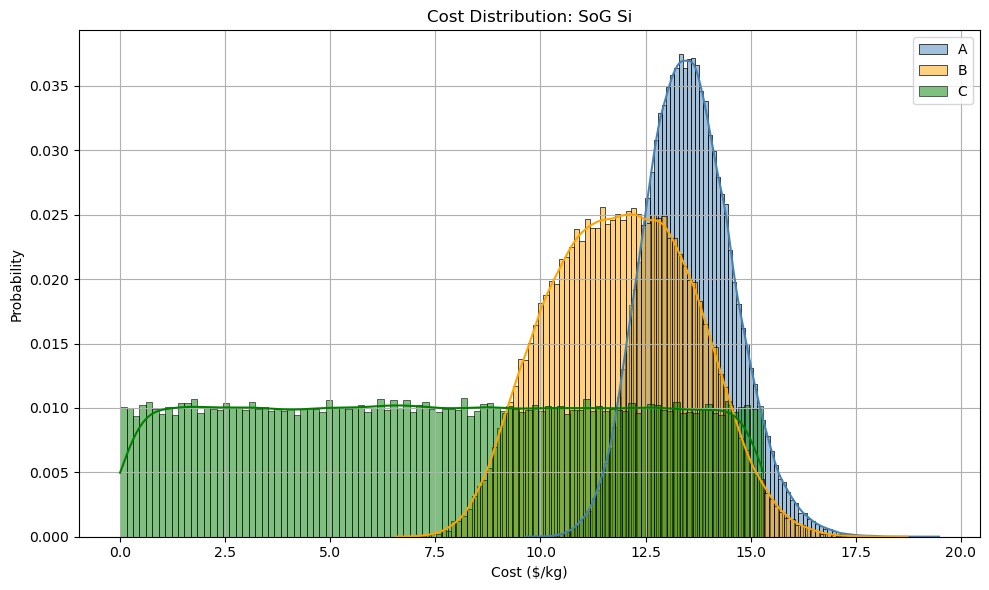

In [25]:
def plot_sog_si_kg():
    print("\nAnalyzing SoG Si costs per kg...")
    colors = ['steelblue', 'orange', 'green', 'red']
    cost_results = generate_costs_by_scenario(df, 'SoG Si', 'kg', conversion_matrix)
    plot_cost_distribution(cost_results, 'Cost Distribution: SoG Si', 'kg', colors)

# Run this function to get SoG Si cost plot
plot_sog_si_kg()


Analyzing wafer costs per wafer...


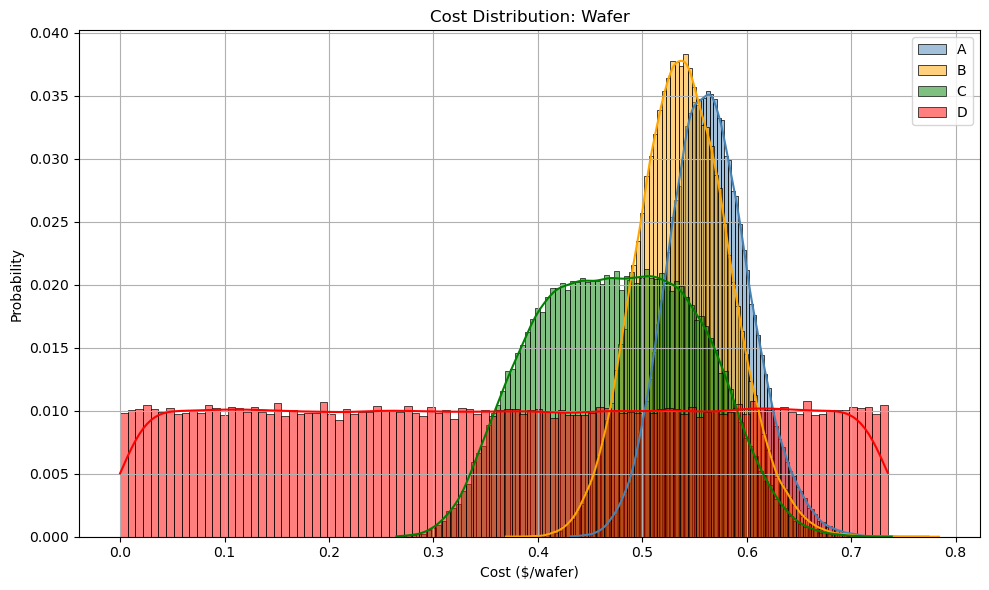

In [26]:
def plot_wafer_cost():
    print("\nAnalyzing wafer costs per wafer...")
    colors = ['steelblue', 'orange', 'green', 'red']
    cost_results = generate_costs_by_scenario(df, 'wafer', 'wafer', conversion_matrix)
    plot_cost_distribution(cost_results, 'Cost Distribution: Wafer', 'wafer', colors)

# Run this function to get wafer cost plot
plot_wafer_cost()


Analyzing cell costs per cell...


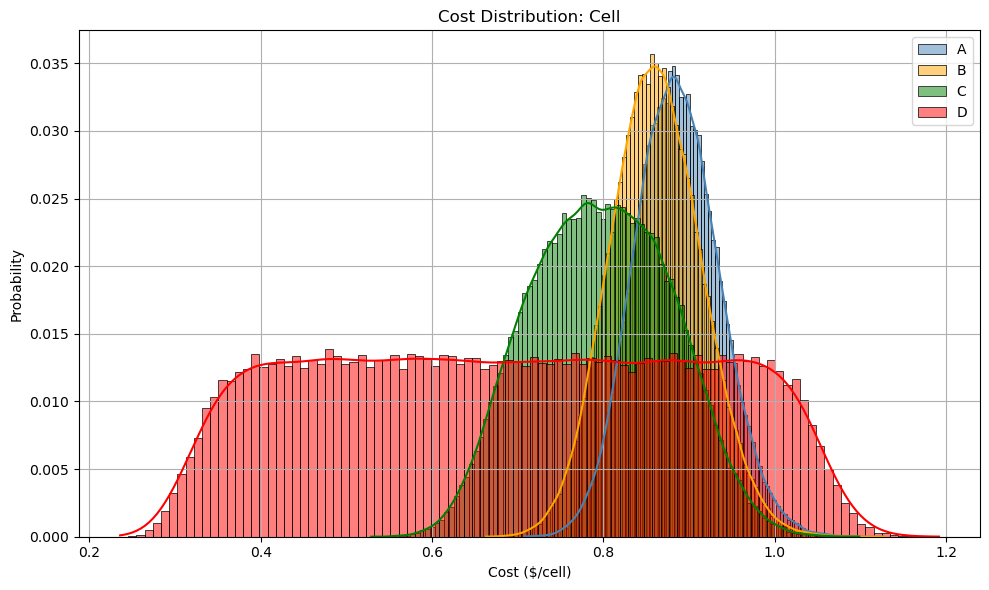

In [27]:
def plot_cell_cost():
    print("\nAnalyzing cell costs per cell...")
    colors = ['steelblue', 'orange', 'green', 'red']
    cost_results = generate_costs_by_scenario(df, 'cell', 'cell', conversion_matrix)
    plot_cost_distribution(cost_results, 'Cost Distribution: Cell', 'cell', colors)

# Run this function to get cell cost plot
plot_cell_cost()


Analyzing module costs per module...


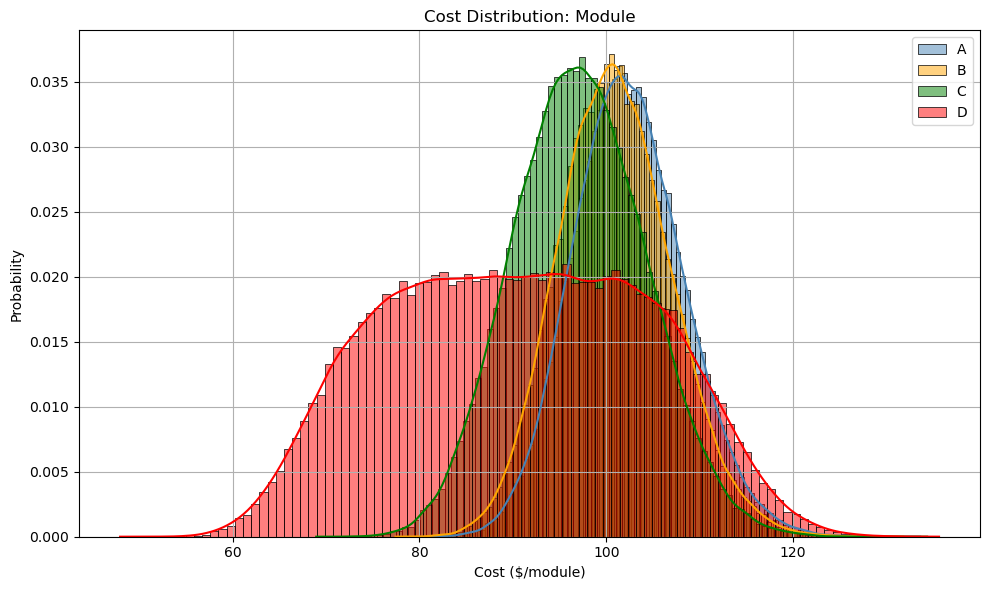

In [28]:
def plot_module_cost():
    print("\nAnalyzing module costs per module...")
    colors = ['steelblue', 'orange', 'green', 'red']
    cost_results = generate_costs_by_scenario(df, 'module', 'module', conversion_matrix)
    plot_cost_distribution(cost_results, 'Cost Distribution: Module', 'module', colors)

# Run this function to get module cost plot
plot_module_cost()


Analyzing cell costs per Watt-peak...


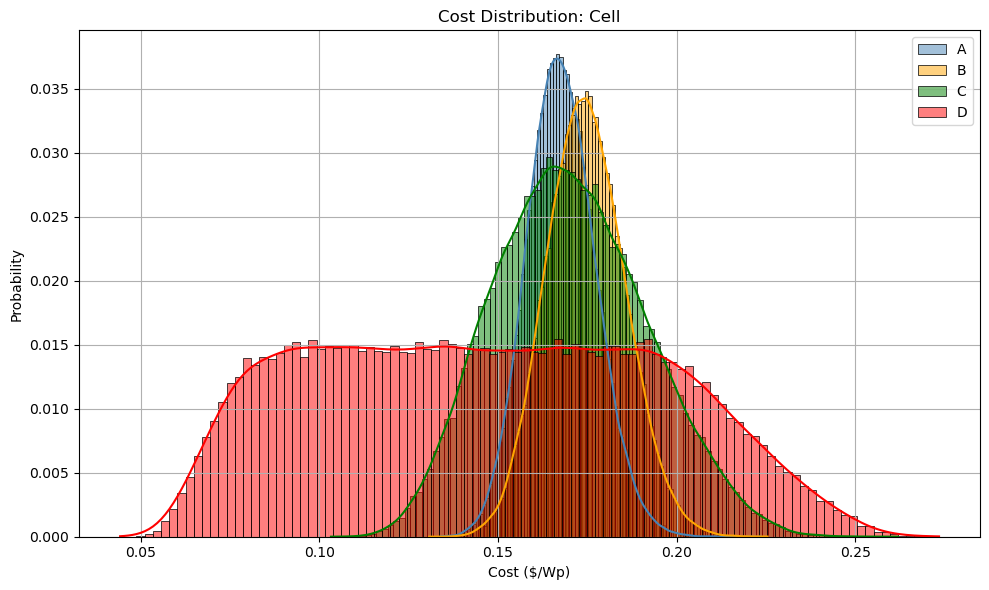

In [30]:
def plot_cell_wp_cost():
    print("\nAnalyzing cell costs per Watt-peak...")
    colors = ['steelblue', 'orange', 'green', 'red']
    cost_results = generate_costs_by_scenario(df, 'cell', 'Wp', conversion_matrix)
    plot_cost_distribution(cost_results, 'Cost Distribution: Cell', 'Wp', colors)

# Run this function to get cell cost per Wp plot
plot_cell_wp_cost()


Analyzing module costs per Watt-peak...


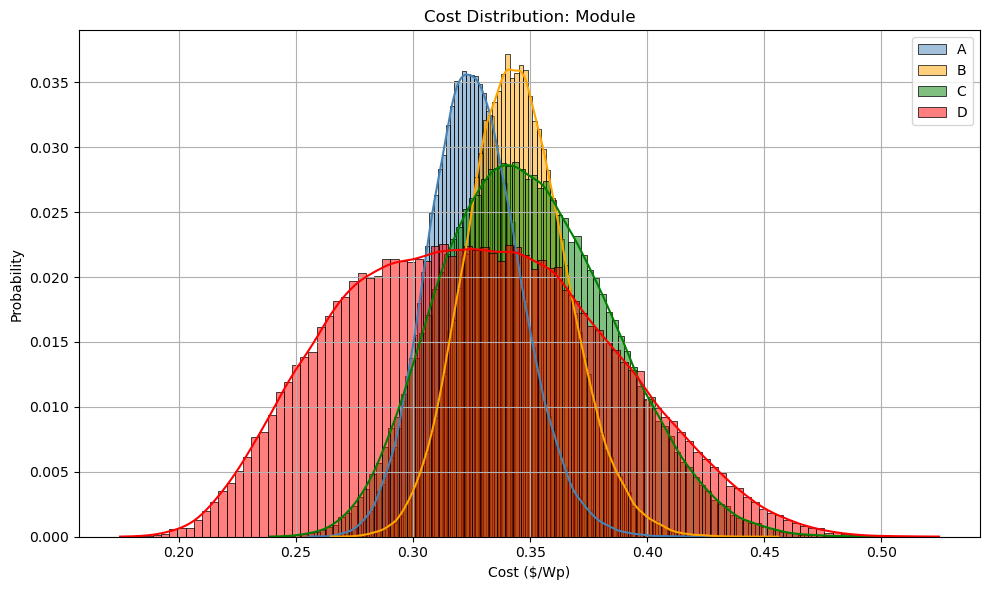

In [31]:
def plot_module_wp_cost():
    print("\nAnalyzing module costs per Watt-peak...")
    colors = ['steelblue', 'orange', 'green', 'red']
    cost_results = generate_costs_by_scenario(df, 'module', 'Wp', conversion_matrix)
    plot_cost_distribution(cost_results, 'Cost Distribution: Module', 'Wp', colors)

# Run this function to get module cost per Wp plot
plot_module_wp_cost()

In [32]:
# Define the contour plot function
def create_contour_plots():
    """Create contour plots comparing recycling scenarios"""
    print("\nGenerating contour plots for recycling scenarios...")

    # Median costs for contour calculations
    C_mg_si = 3.97
    C_sog_processing = 9.5
    C_wafer_processing = 0.36
    C_cell_processing = 0.32
    C_module_processing = 49.0

    # Compute total virgin costs
    C_poly_si = C_mg_si + C_sog_processing
    C_wafer_A = C_poly_si * kg_per_wafer + C_wafer_processing
    C_cell_A = C_wafer_A + C_cell_processing
    C_module_A = cells_per_module * C_cell_A + C_module_processing

    # Power at median efficiency
    P_A = K * median_efficiency

    def cost_difference_C(recycled_cost, eff_reduction):
        """Scenario C vs A: Recycled SoG-Si"""
        C_wafer_C = recycled_cost * kg_per_wafer + C_wafer_processing
        C_cell_C = C_wafer_C + C_cell_processing
        C_module_C = cells_per_module * C_cell_C + C_module_processing

        efficiency_C = median_efficiency - eff_reduction
        P_C = K * efficiency_C

        cpw_A = C_module_A / P_A
        cpw_C = C_module_C / P_C

        return cpw_C - cpw_A

    def cost_difference_D(recycled_cost, eff_reduction):
        """Scenario D vs A: Recovered Wafers"""
        C_wafer_D = recycled_cost
        C_cell_D = C_wafer_D + C_cell_processing
        C_module_D = cells_per_module * C_cell_D + C_module_processing

        efficiency_D = median_efficiency - eff_reduction
        P_D = K * efficiency_D

        cpw_A = C_module_A / P_A
        cpw_D = C_module_D / P_D

        return cpw_D - cpw_A

    # Create colormap
    norm = TwoSlopeNorm(vmin=-0.06, vcenter=0, vmax=0.08)

    # Create figure
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.25)

    # Panel A: Scenario C vs A
    ax = axs[0, 0]
    recycled_costs = np.linspace(0, 15.3, 100)
    eff_reductions = np.linspace(0, 5, 100)
    R, E = np.meshgrid(recycled_costs, eff_reductions)
    Z = np.zeros_like(R)

    for i in range(len(recycled_costs)):
        for j in range(len(eff_reductions)):
            Z[j,i] = cost_difference_C(R[j,i], E[j,i])

    contour = ax.contourf(R, -E, Z, levels=50, cmap='seismic', norm=norm)
    zero_contour = ax.contour(R, -E, Z, levels=[0], colors='white', linewidths=2)
    ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
    contour_lines = ax.contour(R, -E, Z, levels=np.arange(-0.06, 0.07, 0.02),
                               colors='k', linewidths=0.5, alpha=0.7)
    ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

    ax.set_xlabel("Recycled SoG-Si cost ($/kg)", fontsize=12)
    ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
    ax.set_title("(A) Relative cost C vs A ($/W)", fontsize=14)
    ax.grid(alpha=0.2, linestyle='--')
    ax.set_xlim(0, 15.3)
    ax.set_ylim(-5, 0)
    ax.set_yticks([0, -1, -2, -3, -4])

    # Panel B: Scenario C vs A (Cost Difference)
    ax = axs[0, 1]
    virgin_sog_cost = C_poly_si
    recycled_cost_diff = np.linspace(-virgin_sog_cost, 5, 100)
    eff_reductions = np.linspace(0, 5, 100)
    R_diff, E = np.meshgrid(recycled_cost_diff, eff_reductions)
    Z = np.zeros_like(R_diff)

    for i in range(len(recycled_cost_diff)):
        for j in range(len(eff_reductions)):
            abs_cost = virgin_sog_cost + R_diff[j,i]
            Z[j,i] = cost_difference_C(abs_cost, E[j,i])

    contour = ax.contourf(R_diff, -E, Z, levels=50, cmap='seismic', norm=norm)
    zero_contour = ax.contour(R_diff, -E, Z, levels=[0], colors='white', linewidths=2)
    ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
    contour_lines = ax.contour(R_diff, -E, Z, levels=np.arange(-0.06, 0.07, 0.02),
                               colors='k', linewidths=0.5, alpha=0.7)
    ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

    ax.set_xlabel("Cost difference recycled vs virgin Si ($/kg)", fontsize=12)
    ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
    ax.set_title("(B) Relative cost C vs A ($/W)", fontsize=14)
    ax.grid(alpha=0.2, linestyle='--')
    ax.set_xlim(-virgin_sog_cost, 5)
    ax.set_ylim(-5, 0)
    ax.set_yticks([0, -1, -2, -3, -4])

    # Panel C: Scenario D vs A
    ax = axs[1, 0]
    virgin_wafer_cost = C_wafer_A
    recycled_costs = np.linspace(0, 0.6, 100)
    eff_reductions = np.linspace(0, 5, 100)
    R, E = np.meshgrid(recycled_costs, eff_reductions)
    Z = np.zeros_like(R)

    for i in range(len(recycled_costs)):
        for j in range(len(eff_reductions)):
            Z[j,i] = cost_difference_D(R[j,i], E[j,i])

    contour = ax.contourf(R, -E, Z, levels=50, cmap='seismic', norm=norm)
    zero_contour = ax.contour(R, -E, Z, levels=[0], colors='white', linewidths=2)
    ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
    contour_lines = ax.contour(R, -E, Z, levels=np.arange(-0.06, 0.07, 0.02),
                               colors='k', linewidths=0.5, alpha=0.7)
    ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

    ax.set_xlabel("Recovered wafer cost ($/wafer)", fontsize=12)
    ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
    ax.set_title("(C) Relative cost D vs A ($/W)", fontsize=14)
    ax.grid(alpha=0.2, linestyle='--')
    ax.set_xlim(0, 0.6)
    ax.set_ylim(-5, 0)
    ax.set_yticks([0, -1, -2, -3, -4])

    # Panel D: Scenario D vs A (Cost Difference)
    ax = axs[1, 1]
    recycled_cost_diff = np.linspace(-virgin_wafer_cost, 0.2, 100)
    eff_reductions = np.linspace(0, 5, 100)
    R_diff, E = np.meshgrid(recycled_cost_diff, eff_reductions)
    Z = np.zeros_like(R_diff)

    for i in range(len(recycled_cost_diff)):
        for j in range(len(eff_reductions)):
            abs_cost = virgin_wafer_cost + R_diff[j,i]
            Z[j,i] = cost_difference_D(abs_cost, E[j,i])

    contour = ax.contourf(R_diff, -E, Z, levels=50, cmap='seismic', norm=norm)
    zero_contour = ax.contour(R_diff, -E, Z, levels=[0], colors='white', linewidths=2)
    ax.clabel(zero_contour, inline=True, fmt="Break-even", fontsize=10)
    contour_lines = ax.contour(R_diff, -E, Z, levels=np.arange(-0.06, 0.07, 0.02),
                               colors='k', linewidths=0.5, alpha=0.7)
    ax.clabel(contour_lines, inline=True, fontsize=9, fmt="%.3f")

    ax.set_xlabel("Cost difference recovered vs virgin wafer ($/wafer)", fontsize=12)
    ax.set_ylabel("Efficiency reduction (% absolute)", fontsize=12)
    ax.set_title("(D) Relative cost D vs A ($/W)", fontsize=14)
    ax.grid(alpha=0.2, linestyle='--')
    ax.set_xlim(-virgin_wafer_cost, 0.2)
    ax.set_ylim(-5, 0)
    ax.set_yticks([0, -1, -2, -3, -4])

    # Add colorbar
    cbar = fig.colorbar(contour, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label("Net Cost Difference ($/W)", fontsize=12)

    # Add main title
    fig.suptitle("Cost Comparison: Recycling vs Virgin Materials", fontsize=18, y=0.95)

    plt.savefig('recycling_cost_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


Generating contour plots for recycling scenarios...


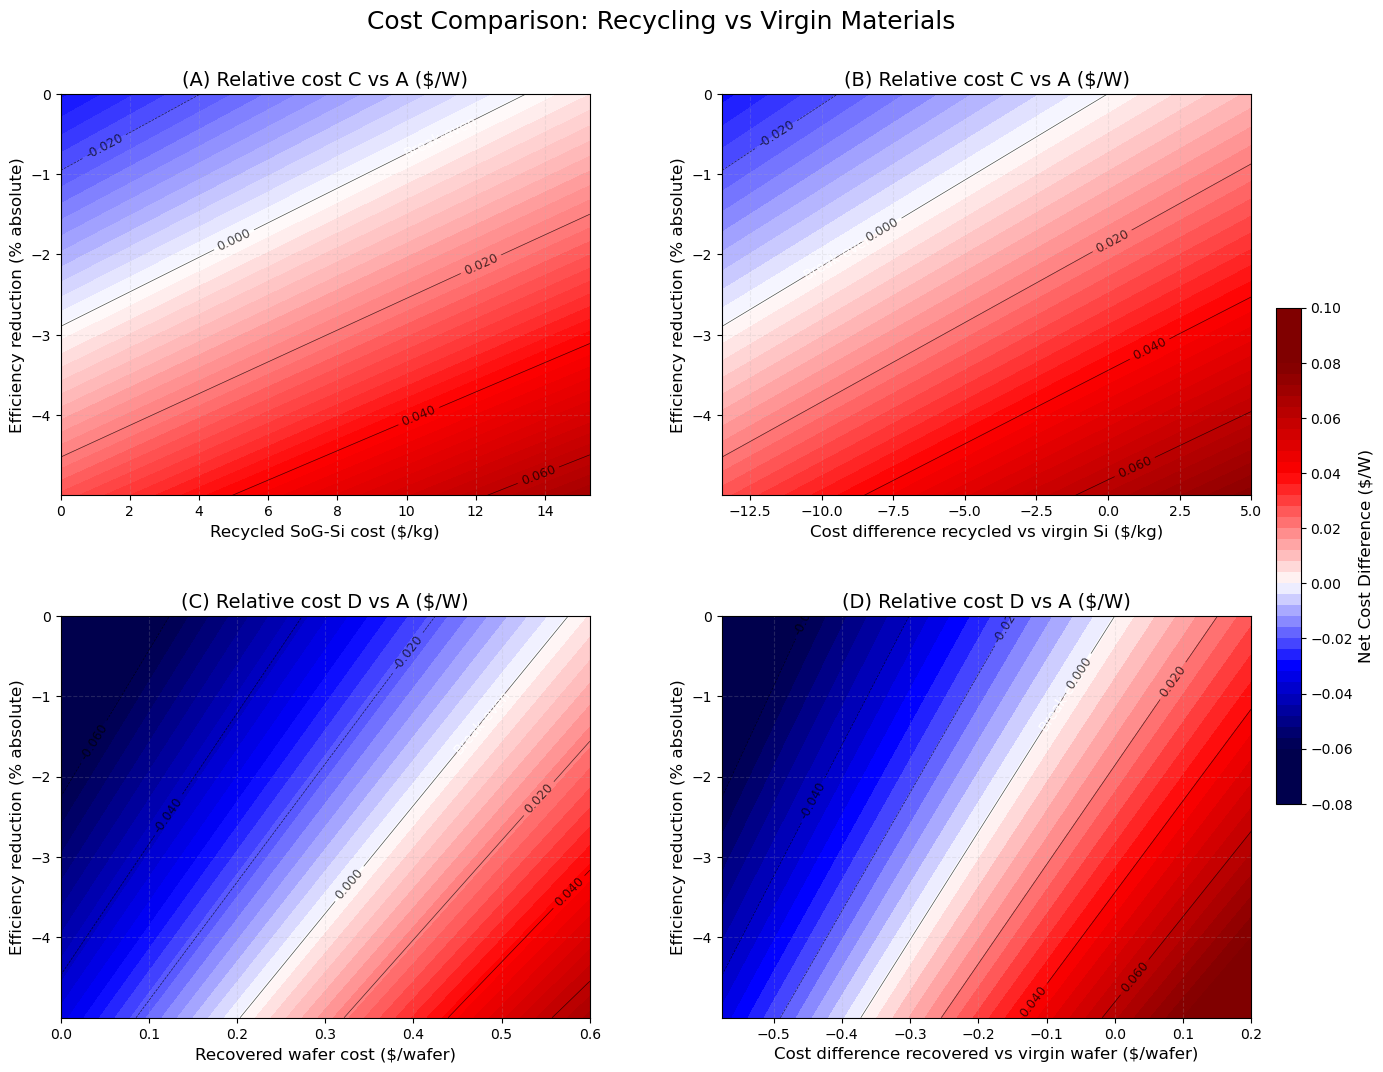

In [33]:
# Contour plot
create_contour_plots()

In [34]:
# Summarize costs for both cell and module in Figure 4, formatted as "median (10th percentile–90th percentile)"
def summarize_costs(cell_results, module_results):
  summary = []
  for scenario in cell_results:
    cell_costs = cell_results[scenario]
    module_costs = module_results[scenario]

    cell_median = np.median(cell_costs)
    cell_p10 = np.percentile(cell_costs, 10)
    cell_p90 = np.percentile(cell_costs, 90)

    module_median = np.median(module_costs)
    module_p10 = np.percentile(module_costs, 10)
    module_p90 = np.percentile(module_costs, 90)

    summary.append({
      'Scenario': scenario,
      'Cell Cost ($/Wp)': f"{cell_median:.2f} ({cell_p10:.2f}-{cell_p90:.2f})",
      'Module Cost ($/Wp)': f"{module_median:.2f} ({module_p10:.2f}-{module_p90:.2f})"
    })

  return pd.DataFrame(summary)

# Recompute costs if not already
target_unit = 'Wp'

production_type = 'cell'
cell_results = generate_costs_by_scenario(df, production_type, target_unit, conversion_matrix)

production_type = 'module'
module_results = generate_costs_by_scenario(df, production_type, target_unit, conversion_matrix)

# Generate and display formatted summary
summary_df = summarize_costs(cell_results, module_results)
display(summary_df)

,Scenario,Cell Cost ($/Wp),Module Cost ($/Wp)
0,A,0.17 (0.16-0.18),0.33 (0.30-0.35)
1,B,0.17 (0.16-0.19),0.34 (0.32-0.37)
2,C,0.17 (0.14-0.20),0.35 (0.30-0.40)
3,D,0.15 (0.08-0.21),0.32 (0.26-0.40)
